#  BPSK Demodulation in Nonlinear Channels with Deep Neural Networks

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates:
* demodulation of BPSK symbols in highly nonlinear channels using an artificial neural network
* variable batch size to improve learning towards lower error rates

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets
%matplotlib inline 

Specify the parameters of the transmission as the fiber length $L$ (in km), the fiber nonlinearity coefficienty $\gamma$ (given in 1/W/km) and the total noise power $P_n$ (given in dBM. The noise is due to amplified spontaneous emission in amplifiers along the link). We assume a model of a dispersion-less fiber affected by nonlinearity. The model, which is described for instance in [1] is given by an iterative application of the equation
$$
x_{k+1} = x_k\exp\left(\jmath\frac{L}{K}\gamma|x_k|^2\right) + n_{k+1},\qquad 0 \leq k < K
$$
where $x_0$ is the channel input (the modulated, complex symbols) and $x_K$ is the channel output. $K$ denotes the number of steps taken to simulate the channel Usually $K=50$ gives a good approximation.

[1] S. Li, C. Häger, N. Garcia, and H. Wymeersch, "Achievable Information Rates for Nonlinear Fiber Communication via End-to-end Autoencoder Learning," Proc. ECOC, Rome, Sep. 2018

In [37]:
# Length of transmission (in km)
L = 5000

# fiber nonlinearity coefficient
gamma = 1.27

Pn = -21.3 # noise power (in dBm)

Kstep = 50 # number of steps used in the channel model

# noise variance per step    
sigma_n = np.sqrt((10**((Pn-30)/10)) / Kstep / 2)    

def simulate_channel(x, Pin):  
    # modulate bpsk
    input_power_linear = 10**((Pin-30)/10)
    norm_factor = np.sqrt(input_power_linear);
    bpsk = (1 - 2*x) * norm_factor
    

    temp = np.array(bpsk, copy=True)
    for i in range(Kstep):
        power = np.absolute(temp)**2
        rotcoff = (L / Kstep) * gamma * power
        
        temp = temp * np.exp(1j*rotcoff) + sigma_n*(np.random.randn(len(x)) + 1j*np.random.randn(len(x)))
    return temp

We consider BPSK transmission over this channel.

Show constellation as a function of the fiber input power. When the input power is small, the effect of the nonlinearity is small (as $\jmath\frac{L}{K}\gamma|x_k|^2 \approx 0$) and the transmission is dominated by the additive noise. If the input power becomes larger, the effect of the noise (the noise power is constant) becomes less pronounced, but the constellation rotates due to the larger input power and hence effect of the nonlinearity.

In [24]:
length = 5000

def plot_constellation(Pin):
    t = np.random.randint(2,size=length)
    r = simulate_channel(t, Pin)

    plt.figure(figsize=(6,6))
    font = {'size'   : 14}
    plt.rc('font', **font)
    plt.rc('text', usetex=True)
    plt.scatter(np.real(r), np.imag(r), c=t, cmap='coolwarm')
    plt.xlabel(r'$\Re\{r\}$',fontsize=14)
    plt.ylabel(r'$\Im\{r\}$',fontsize=14)
    plt.axis('equal')
    plt.title('Received constellation (L = %d km, $P_{in} = %1.2f$\,dBm)' % (L, Pin))    
    plt.savefig('bpsk_received_zd_%1.2f.pdf' % Pin,bbox_inches='tight')
    
interactive_update = interactive(plot_constellation, Pin = widgets.FloatSlider(min=-10.0,max=10.0,step=0.1,value=1, continuous_update=False, description='Input Power Pin (dBm)', style={'description_width': 'initial'}, layout=widgets.Layout(width='50%')))


output = interactive_update.children[-1]
output.layout.height = '500px'
interactive_update

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Input Power Pin (dBm)', lay…

Helper function to compute Bit Error Rate (BER)

In [6]:
# helper function to compute the bit error rate
def BER(predictions, labels):
    decision = predictions >= 0.5
    return np.mean(decision != labels)

Here, we define the parameters of the neural network and training, generate the validation set and a helping set to show the decision regions

In [69]:
# set input power
Pin = 5
input_power_linear = 10**((Pin-30)/10)
norm_factor = np.sqrt(input_power_linear);

# validation set. Training examples are generated on the fly
N_valid = 100000

# number of neurons in hidden layers
hidden_neurons_1 = 8
hidden_neurons_2 = 14


y_valid = np.random.randint(2,size=N_valid)
r = simulate_channel(y_valid, Pin)

# find extension of data (for normalization and plotting)
ext_x = max(abs(np.real(r)))
ext_y = max(abs(np.imag(r)))
ext_max = max(ext_x,ext_y)*1.2

# scale data to be between 0 and 1
X_valid = np.column_stack((np.real(r), np.imag(r))) / ext_max


# meshgrid for plotting
mgx,mgy = np.meshgrid(np.linspace(-ext_max,ext_max,200), np.linspace(-ext_max,ext_max,200))
meshgrid = np.column_stack((np.reshape(mgx,(-1,1)),np.reshape(mgy,(-1,1)))) / ext_max

This is the main function of TensorFlow that generates the computation graph. We have a single interface to the outside (a `tf.placeholder` which is the batch size. Here the idea is to vary the batch size during training. In the first iterations, we start with a small batch size to rapidly get to a working solution. The closer we come towards the end of the training we increase the batch size. If keeping the abtch size small, it may happen that there are no misclassifications in a small batch and there is no incentive of the training to improve. A larger batch size will most likely contain errors in the batch and hence there will be incentive to keep on training and improving. 

Here, the data is generated on the fly inside the graph, by using TensorFlows random number generation. As TensorFlow does not natively support complex numbers (at least in early versions), we decided to replace the complex number operations in the channel by a simple rotation matrix and treating real and imaginary parts separately.

We use the ELU activation function inside the neural network and employ the Adam optimization algorithm.

In [70]:
# generate graph
graph = tf.Graph()

with graph.as_default():    
    # placeholder for training data (passed from externally)
    tf_batch_size = tf.placeholder(tf.int32, shape=())

    # the validation dataset
    tf_valid_dataset = tf.constant(X_valid, dtype=tf.float32)
    tf_valid_labels = tf.constant(y_valid, dtype=tf.float32)

    # the mesgrid for plotting the decision region
    tf_meshgrid = tf.constant(meshgrid, dtype=tf.float32)
    
    # generate random data
    batch_labels = tf.to_float(tf.random_uniform(shape=[tf_batch_size], dtype=tf.int32, minval=0, maxval=2))

    # convert to 2d representation (real and imaginary part)
    bpsk = tf.expand_dims((1 - 2*batch_labels) * norm_factor, 1) * np.array([1,0])

    # simulate the channel
    for i in range(Kstep):
        power = tf.norm(bpsk, axis=1) ** 2
        rotcoff = (L / Kstep) * gamma * power
        
        # rotation matrix corresponding to exp(1j*rotcoff)        
        temp = tf.stack([bpsk[:,0] * tf.cos(rotcoff) - bpsk[:,1]*tf.sin(rotcoff), bpsk[:,0]*tf.sin(rotcoff)+bpsk[:,1]*tf.cos(rotcoff)], axis=1)        
        bpsk = temp + tf.random_normal(shape=(tf_batch_size,2), stddev=sigma_n)

    batch_data = bpsk / ext_max
    
    # define neural network by hand
    # assume 2 hidden layers with ELU functions and a logistic output function
    W1 = tf.Variable(tf.truncated_normal([2,hidden_neurons_1], stddev=0.8)) 
    b1 = tf.Variable(tf.truncated_normal([hidden_neurons_1], stddev=0.8))
    
    W2 = tf.Variable(tf.truncated_normal([hidden_neurons_1,hidden_neurons_2], stddev=0.8))
    b2 = tf.Variable(tf.truncated_normal([hidden_neurons_2], stddev=0.8))
    
    W3 = tf.Variable(tf.truncated_normal([hidden_neurons_2,1], stddev=0.8))
    b3 = tf.Variable(tf.truncated_normal([1], stddev=0.8))
    
    def neural_network(inp):
        temp1 = tf.nn.elu(tf.matmul(inp, W1)+b1)
        temp2 = tf.nn.elu(tf.matmul(temp1, W2)+b2)
        # note that the sigmoid is not part of the neural network, but of the loss function later. This saves some complexity        
        # squeeze removes the extra dimension and makes the output scalar
        return tf.squeeze(tf.matmul(temp2, W3)+b3)
    
    #output of the neural network
    logits = neural_network(batch_data)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=batch_labels, logits=logits))    

    # equivalent formulation without using tensorflow's intern function
    #loss = tf.reduce_mean(-tf_train_labels * tf.log(tf.sigmoid(logits)) - (1-tf_train_labels)*tf.log(1-tf.sigmoid(logits)))
    
    # use Adap optimizer
    optimizer = tf.train.AdamOptimizer().minimize(loss)
    
    # predictions for training, validation and test data    
    valid_prediction = tf.nn.sigmoid(neural_network(tf_valid_dataset))
        
    # mesh prediction for plotting
    mesh_prediction = tf.nn.sigmoid(neural_network(tf_meshgrid))    

Now, carry out the training as such. First initialize the variables and then loop through the training. Here, the epochs are not defined in the classical way, as we do not have a training set per se. We generate new data on the fly and never reuse data.

In [74]:
num_epochs = 160
batches_per_epoch = 300

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs)

validation_BERs = np.zeros(num_epochs)
decision_region_evolution = []

with tf.Session(graph=graph) as session:
    # initialize variables
    tf.global_variables_initializer().run()

    print('Initialized')
    for epoch in range(num_epochs):
        for step in range(batches_per_epoch):
            feed_dict = {tf_batch_size : batch_size_per_epoch[epoch] }
            
            # run an optimization step
            _ = session.run(optimizer, feed_dict=feed_dict)
        
        # compute validation BER
        valid_out = valid_prediction.eval()
        validation_BERs[epoch] = BER(valid_out, y_valid)
        print('Validation BER after epoch %d: %f' % (epoch, validation_BERs[epoch]))                
        
        # store decision region for generating the animation
        decision_region_evolution.append(0.195*mesh_prediction.eval() + 0.4)

Initialized
Validation BER after epoch 0: 0.045330
Validation BER after epoch 1: 0.045230
Validation BER after epoch 2: 0.045100
Validation BER after epoch 3: 0.045050
Validation BER after epoch 4: 0.045050
Validation BER after epoch 5: 0.044980
Validation BER after epoch 6: 0.044920
Validation BER after epoch 7: 0.044920
Validation BER after epoch 8: 0.044760
Validation BER after epoch 9: 0.044780
Validation BER after epoch 10: 0.044720
Validation BER after epoch 11: 0.044470
Validation BER after epoch 12: 0.044460
Validation BER after epoch 13: 0.044330
Validation BER after epoch 14: 0.043670
Validation BER after epoch 15: 0.043080
Validation BER after epoch 16: 0.042290
Validation BER after epoch 17: 0.041680
Validation BER after epoch 18: 0.040410
Validation BER after epoch 19: 0.038880
Validation BER after epoch 20: 0.036740
Validation BER after epoch 21: 0.034680
Validation BER after epoch 22: 0.031670
Validation BER after epoch 23: 0.028610
Validation BER after epoch 24: 0.02202

Plt decision region and scatter plot of the validation set. Note that the validation set is **only** used for computing BERs and plotting, there is no feedback towards the training!

<IPython.core.display.Javascript object>


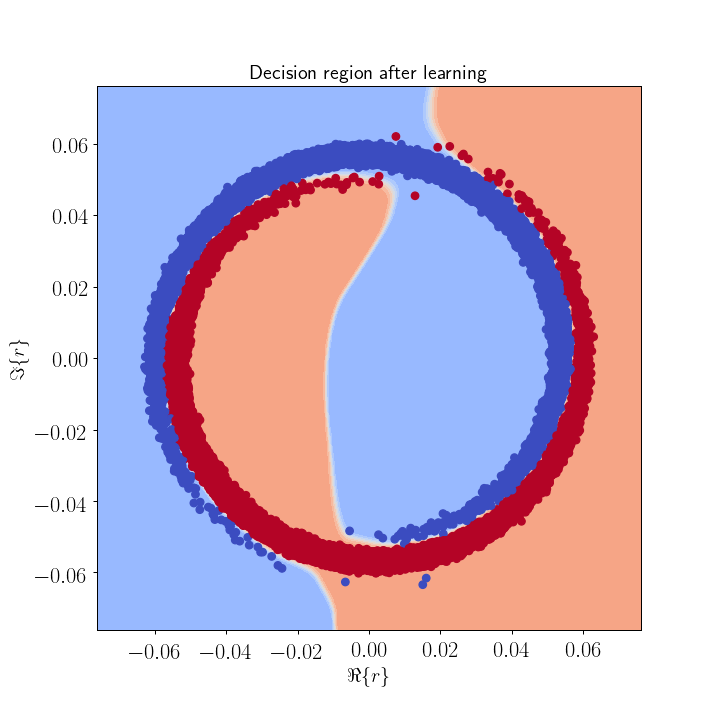

In [75]:
plt.figure(figsize=(8,8))
plt.contourf(mgx,mgy,decision_region_evolution[-1].reshape(mgy.shape).T,cmap='coolwarm',vmin=0.3,vmax=0.7)
plt.scatter(X_valid[:,0]*ext_max, X_valid[:,1]*ext_max, c=y_valid, cmap='coolwarm')
plt.axis('scaled')
plt.xlabel(r'$\Re\{r\}$',fontsize=16)
plt.ylabel(r'$\Im\{r\}$',fontsize=16)
plt.title('Decision region after learning',fontsize=16)
#plt.savefig('decision_region_Pin%d.pdf' % Pin,bbox_inches='tight')

Generate animation and save as a gif.

<IPython.core.display.Javascript object>


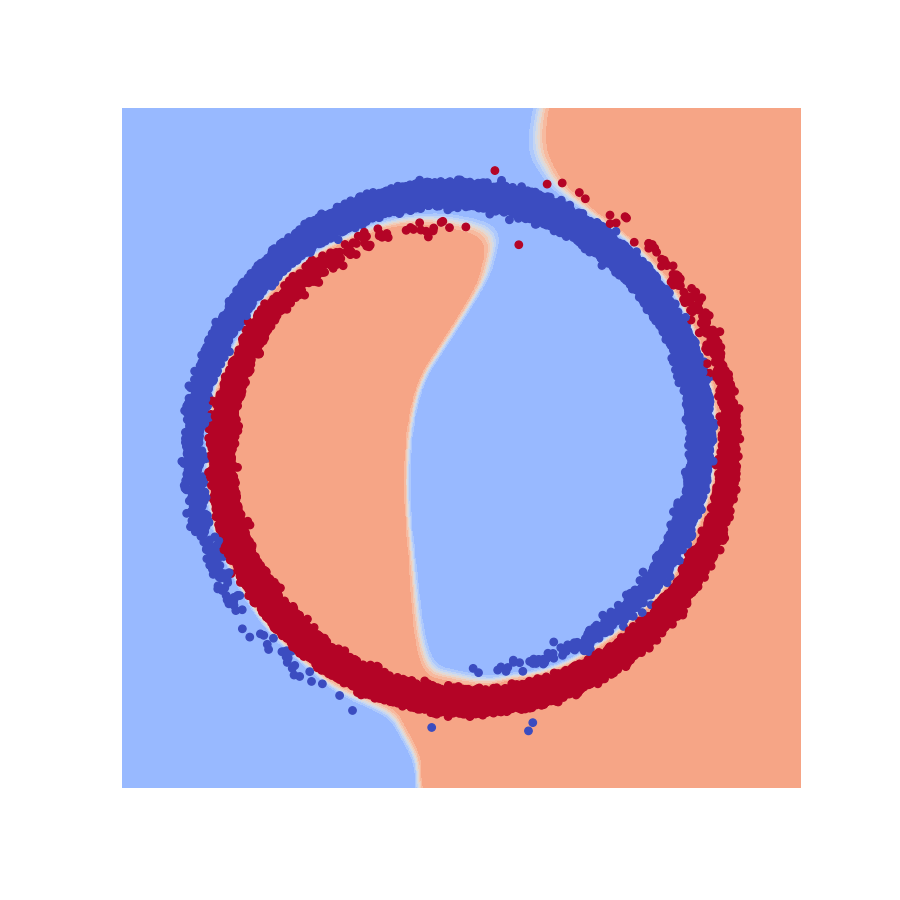

In [76]:
%matplotlib notebook
%matplotlib notebook
# Generate animation
from matplotlib import animation, rc
#from matplotlib.animation import PillowWriter # Disable if you don't want to save any GIFs.

font = {'size'   : 18}
plt.rc('font', **font)

fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim(( -ext_max, ext_max))
ax.set_ylim(( -ext_max, ext_max))
ax.axis('scaled')

written = False
def animate(i):
    ax.clear()

    ax.contourf(mgx,mgy,decision_region_evolution[i].reshape(mgy.shape).T,cmap='coolwarm',vmin=0.3,vmax=0.7)
    ax.scatter(X_valid[:,0]*ext_max, X_valid[:,1]*ext_max, c=y_valid, cmap='coolwarm')
    ax.set_xlabel(r'$\Re\{r\}$',fontsize=18)
    ax.set_ylabel(r'$\Im\{r\}$',fontsize=18)

    
anim = animation.FuncAnimation(fig, animate, frames=len(decision_region_evolution), interval=200, blit=False)
fig.show()
#anim.save('learning_decision_BPSK_Pin%d_varbatch.gif' % Pin, writer=PillowWriter(fps=7))